In [1]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

In [2]:
games = pd.read_csv("/Users/elisabethkollrack/Thesis/EK-thesis/game_attention.csv")
# adjust attention
# take log of attention
games['log_attention'] = np.log1p(games['attention'])

games['date'] = pd.to_datetime(games['date'])
games['gametime'] = games['gametime'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

categorical_cols = ['weekday', 'home_team', 'away_team']
games_encoded = pd.get_dummies(games, columns=categorical_cols, drop_first=True)

X = games_encoded.drop(columns=['attention','log_attention', 'game_id', 'date'])  # only numeric/coded features
y = games_encoded['log_attention']

categorical_cols = ['weekday', 'home_team', 'away_team']
games_encoded = pd.get_dummies(games, columns=categorical_cols, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
xgb = XGBRegressor(
    n_estimators=500,       # number of boosting rounds (trees)
    learning_rate=0.05,     # smaller → slower but more accurate
    max_depth=6,            # tree depth
    subsample=0.8,          # sample of rows per tree
    colsample_bytree=0.8,   # sample of columns per tree
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost R²: {r2_xgb}")


XGBoost RMSE: 0.999864898045371
XGBoost R²: 0.43452357754502224


In [4]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1
)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_

y_pred_best = best_xgb.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
best_r2 = r2_score(y_test, y_pred_best)

print("\nBest Parameters Found:")
print(random_search_xgb.best_params_)
print(f"Tuned XGBoost RMSE: {best_rmse}")
print(f"Tuned XGBoost R²: {best_r2}")


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=800, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=600, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=600, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=600, subsample=0.6; total time=   0.7s
[CV] END colsamp

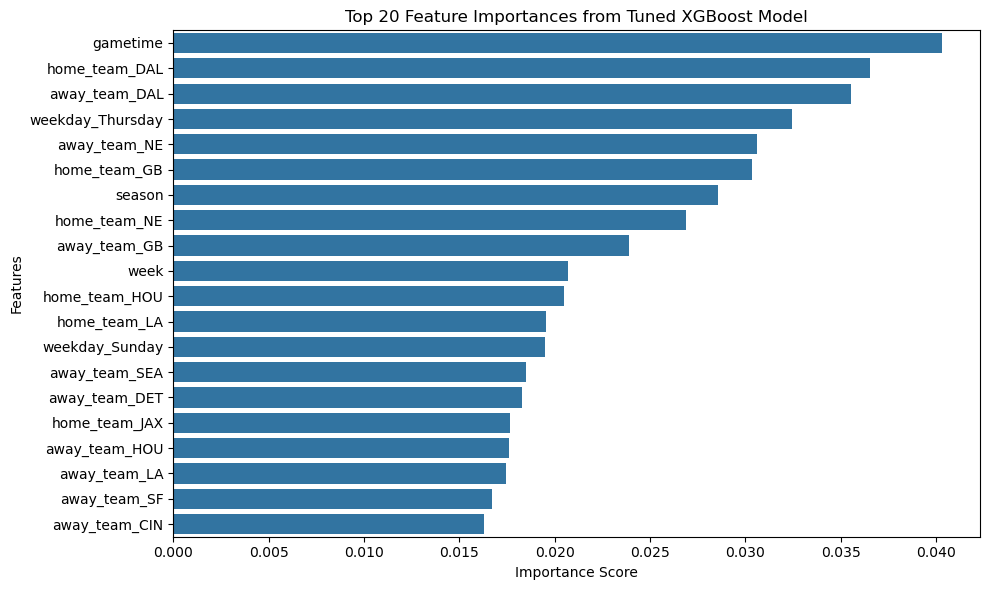

In [5]:
# most important features
importances = best_xgb.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title('Top 20 Feature Importances from Tuned XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
